# Binary Classification

# Task 1: Logistic Regression

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the dataset

In [2]:
X_train_fpath = './data/X_train'
y_train_fpath = './data/Y_train'
X_test_fpath =  './data/X_test'
output_fpath = './output_{}.csv'

# parse the csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

with open(y_train_fpath) as f:
    next(f)
    y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)

with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(54256, 510)
(54256,)
(27622, 510)


## Defining data preprocessing functions

In [4]:
def _normalize(X, train=True, specified_column=None, X_mean=None, X_std=None):
    """
    This function normalizes specific columns of X.
    The mean and standard variance of training data will be reused when processing testing data.
    
    Arguments:
        X: data to be processed.
        train: 'True' when processing training data. 'False' when processing testing data.
        specified_column: indexes of the columns that will be normalized. If 'None', all columns will be normalized.
        X_mean: mean value of the training data, used when train='False'.
        X_std: standard deviation of the training data, used when train='False'.
    
    Outputs:
        X: normalized data.
        X_mean: computed mean value of the training data.
        X_std: computed standard deviation of the training data.
    """
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column], 0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], 0).reshape(1, -1)
    X[:, specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
    
    return X, X_mean, X_std


def _train_dev_split(X, y, dev_ratio=0.25):
    """
    This function spilts data into training set and development set.
    """
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]

## Data preprocessing

In [5]:
# Normalizing the training and testing data
X_train, X_mean, X_std = _normalize(X_train, train=True)
X_test, _, _ = _normalize(X_test, train=False, specified_column=None, X_mean=X_mean, X_std=X_std)

# Spliting the data into training and development set
dev_ratio = 0.1
X_train, y_train, X_dev, y_dev = _train_dev_split(X_train, y_train, dev_ratio=dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]

print('Size of the training set: {}'.format(train_size))
print('Size of the development set: {}'.format(dev_size))
print('Size of the testing set: {}'.format(test_size))
print('Size of the data dimension: {}'.format(data_dim))

Size of the training set: 48830
Size of the development set: 5426
Size of the testing set: 27622
Size of the data dimension: 510


## Defining some useful functions
- Some functions that will be repeatedly used when iteratively updating the parameters.

In [6]:
def _shuffle(X, y):
    """
    This function shuffles two equal-length list/array, X and Y, together.
    """
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], y[randomize])


def _sigmoid(z):
    """
    Sigmoid function can be used to calculate probability.
    To avoid overflow, minimum/maximum output value is set.
    """
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))


def _f(X, w, b):
    """
    This is the logistic regression function, parameterized by w and b.

    Arguments:
        X: input data, shape=[batch_size, data_dimension]
        w: weight vector, shape=[data_dimension]
        b: bias, scalar
    
    Output:
        predicted probability of each row of X being postively labeled, shape=[batch_size, ]
    """
    return _sigmoid(np.matmul(X, w) + b)


def _predict(X, w, b):
    """
    This function returns a truth value prediction for each row of X by rounding the result of logistic regression function.
    """
    return np.round(_f(X, w, b)).astype(np.int)


def _accuracy(y_pred, y_label):
    """
    This function calculates prediction accuracy
    """
    acc = 1 - np.mean(np.abs(y_pred - y_label))
    return acc

## Functions about gradient and loss

In [7]:
def _cross_entropy_loss(y_pred, y_label):
    """
    This function computes the cross entropy.

    Arguments:
        y_pred: probabilistic predictions, float vector.
        y_label: ground truth labels, bool vector.

    Outputs:
        cross entropy, scalar.
    """
    cross_entropy = -np.dot(y_label, np.log(y_pred)) - np.dot((1 - y_label), np.log(1 - y_pred))
    return cross_entropy


def _gradient(X, y_label, w, b):
    """
    This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    """
    y_pred = _f(X, w, b)
    pred_error = y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

## Training the model 

- We'll use the gradient descent method with small batches for training.
- The training data is divided into many small batches. For each small batch, we calculate the gradient and loss separately. Then, update the model parameters according to the batch.
- When a loop is completed, that is, after all the small batches of the entire training set have been used **once**, we will break up all the training data and re-divide them into new small batches. Then, proceed to the next loop until finishing all loops.

In [8]:
# zero initialization for weights and bias
w = np.zeros((data_dim, ))
b = np.zeros((1, ))

# some parameters for training
max_iter = 10
batch_size = 8
learning_rate = 0.2

# keep the loss and accuracy for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# calculate the number of parameter updates
step = 1

# iterative training
for epoch in range(max_iter):
    # random shuffle at the beginning of each epoch
    X_train, y_train = _shuffle(X_train, y_train)

    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx * batch_size : (idx + 1) * batch_size]
        y = y_train[idx * batch_size : (idx + 1) * batch_size]

        # compute the gradient
        w_grad, b_grad = _gradient(X, y, w, b)

        # gradient descent updates
        # learning rate decay with time
        w = w - learning_rate / np.sqrt(step) * w_grad
        b = b - learning_rate / np.sqrt(step) * b_grad

        step += 1

    # compute the loss and accuracy of the training set and development set
    y_train_pred = _f(X_train, w, b) # float
    Y_train_pred = np.round(y_train_pred) # bool
    train_acc.append(_accuracy(Y_train_pred, y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b) # float
    Y_dev_pred = np.round(y_dev_pred) # bool
    dev_acc.append(_accuracy(Y_dev_pred, y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, y_dev) / dev_size) 

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.272853645611585
Development loss: 0.29365746202333487
Training accuracy: 0.8830841695678886
Development accuracy: 0.8744931809804645


## Plotting loss and accuracy curve

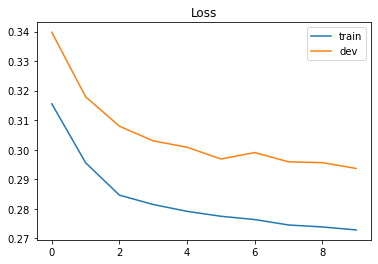

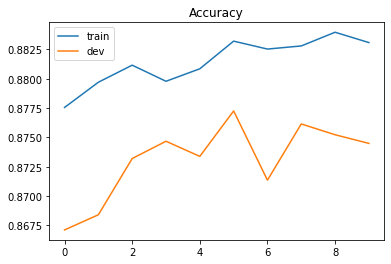

In [9]:
# loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

## Predicting the testing labels

In [10]:
import csv

predictions = _predict(X_test, w, b)
with open('output_logistic.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'label']
    print(header)
    csv_writer.writerow(header)
    for i in range(len(predictions)):
        row = [str(i+1), predictions[i]]
        csv_writer.writerow(row)
        print(row)
    print()

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1] # Arrange the array in an ascending order and take it from the end to the front
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0 : 10]:
    print(features[i], w[i])

;, 0]
[&#39;26687&#39;, 1]
[&#39;26688&#39;, 1]
[&#39;26689&#39;, 0]
[&#39;26690&#39;, 0]
[&#39;26691&#39;, 0]
[&#39;26692&#39;, 0]
[&#39;26693&#39;, 1]
[&#39;26694&#39;, 0]
[&#39;26695&#39;, 0]
[&#39;26696&#39;, 0]
[&#39;26697&#39;, 0]
[&#39;26698&#39;, 0]
[&#39;26699&#39;, 1]
[&#39;26700&#39;, 0]
[&#39;26701&#39;, 0]
[&#39;26702&#39;, 0]
[&#39;26703&#39;, 1]
[&#39;26704&#39;, 0]
[&#39;26705&#39;, 0]
[&#39;26706&#39;, 0]
[&#39;26707&#39;, 0]
[&#39;26708&#39;, 0]
[&#39;26709&#39;, 0]
[&#39;26710&#39;, 0]
[&#39;26711&#39;, 0]
[&#39;26712&#39;, 0]
[&#39;26713&#39;, 0]
[&#39;26714&#39;, 0]
[&#39;26715&#39;, 0]
[&#39;26716&#39;, 0]
[&#39;26717&#39;, 0]
[&#39;26718&#39;, 1]
[&#39;26719&#39;, 0]
[&#39;26720&#39;, 0]
[&#39;26721&#39;, 0]
[&#39;26722&#39;, 0]
[&#39;26723&#39;, 0]
[&#39;26724&#39;, 0]
[&#39;26725&#39;, 0]
[&#39;26726&#39;, 0]
[&#39;26727&#39;, 0]
[&#39;26728&#39;, 0]
[&#39;26729&#39;, 0]
[&#39;26730&#39;, 0]
[&#39;26731&#39;, 0]
[&#39;26732&#39;, 1]
[&#39;26733&#39;, 0]
[&#39;2

# Task 2: Porbabilistic generative model
- Implement a binary classifier based on a generative model

## Loading the dataset

In [11]:
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

with open(y_train_fpath) as f:
    next(f)
    y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)

with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

## Data preprocessing

In [12]:
# Normalizing the training and testing data
X_train, X_mean, X_std = _normalize(X_train, train=True)
X_test, _, _ = _normalize(X_test, train=False, specified_column=None, X_mean=X_mean, X_std=X_std)

## Calculating the Mean and Covariance
- In the generative model, we need to calculate the average and covariance of the data in the two categories separately.

In [13]:
# compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis=0)
mean_1 = np.mean(X_train_1, axis=0)

# compute the in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    # np.transpose([x - mean_0]).shape -> (510, 1)
    # [x - mean_0].shape -> (1, 510)
    # np.dot(np.transpose([x - mean_0]), [x - mean_0]).shape -> (510, 510)
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]

for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

## Computing weights and bias
- The weight matrix and deviation vector can be directly calculated.

In [14]:
# Compute the inverse of covariance matrix
# Since the covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error
# Via SVD decomposition, one can get matrix inverse efficiently and accurately
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b = -0.5 * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1)) \
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0])

# Compute accuracy on training set
y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(y_train_pred, y_train)))

Training accuracy: 0.8548363314656444


## Predicting testing labels

In [15]:
import csv

predictions = _predict(X_test, w, b)
with open('output_generative.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'label']
    print(header)
    csv_writer.writerow(header)
    for i in range(len(predictions)):
        row = [str(i+1), predictions[i]]
        csv_writer.writerow(row)
        print(row)
    print()

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1] # Arrange the array in an ascending order and take it from the end to the front
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0 : 10]:
    print(features[i], w[i])

&#39;26688&#39;, 0]
[&#39;26689&#39;, 1]
[&#39;26690&#39;, 1]
[&#39;26691&#39;, 1]
[&#39;26692&#39;, 1]
[&#39;26693&#39;, 1]
[&#39;26694&#39;, 1]
[&#39;26695&#39;, 1]
[&#39;26696&#39;, 1]
[&#39;26697&#39;, 1]
[&#39;26698&#39;, 1]
[&#39;26699&#39;, 1]
[&#39;26700&#39;, 1]
[&#39;26701&#39;, 1]
[&#39;26702&#39;, 1]
[&#39;26703&#39;, 0]
[&#39;26704&#39;, 1]
[&#39;26705&#39;, 1]
[&#39;26706&#39;, 1]
[&#39;26707&#39;, 1]
[&#39;26708&#39;, 1]
[&#39;26709&#39;, 1]
[&#39;26710&#39;, 1]
[&#39;26711&#39;, 1]
[&#39;26712&#39;, 1]
[&#39;26713&#39;, 1]
[&#39;26714&#39;, 1]
[&#39;26715&#39;, 1]
[&#39;26716&#39;, 1]
[&#39;26717&#39;, 1]
[&#39;26718&#39;, 1]
[&#39;26719&#39;, 1]
[&#39;26720&#39;, 1]
[&#39;26721&#39;, 1]
[&#39;26722&#39;, 1]
[&#39;26723&#39;, 1]
[&#39;26724&#39;, 1]
[&#39;26725&#39;, 0]
[&#39;26726&#39;, 1]
[&#39;26727&#39;, 1]
[&#39;26728&#39;, 1]
[&#39;26729&#39;, 1]
[&#39;26730&#39;, 1]
[&#39;26731&#39;, 1]
[&#39;26732&#39;, 0]
[&#39;26733&#39;, 1]
[&#39;26734&#39;, 1]
[&#39;26735&#3